# imports, start

In [1]:
%config Completer.use_jedi = False

In [2]:
import requests
import json
import pandas as pd
import os
import rasterio

In [3]:
raster_coords = pd.read_csv('data/bounding_boxes_coordinates')
raster_coords.set_index('index', inplace=True)

# Requests

In [4]:
def get_info_from_adress(params):
    """
    From an adress, get the coordinates and the polygon of the buildings
    """
    diccie = {}
    request = requests.get(
        "https://api.basisregisters.vlaanderen.be/v1/adresmatch", 
        params=params).content
    jayson = json.loads(request)
    adress_obj = jayson['adresMatches'][0]['adresseerbareObjecten']

    diccie['adress_coords'] = jayson['adresMatches'][0]['adresPositie']['point']['coordinates']
    adress_objects = jayson['adresMatches'][0]['adresseerbareObjecten']
    polygons = []
    for obj in adress_objects:
        if obj['objectType'] == 'gebouweenheid':
            polygons.append(get_polygon_from_detail_url_gebouweenheid(obj['detail']))
    return polygons

In [5]:
def request_json_content(url: str, params: dict) -> dict:
    request = requests(url, params)
    content = request.content
    jayson = json.loads(content)
    return jayson

In [6]:
def get_polygon_from_detail_url_gebouweenheid(url):
    request = requests.get(url).content
    jayson = json.loads(request)
    request_poly = requests.get(jayson['gebouw']['detail']).content
    jayson_poly = json.loads(request_poly)
    poly = jayson_poly['geometriePolygoon']['polygon']['coordinates']
    return poly


In [11]:
params = {"postcode": 3550, "straatnaam": 'kapelstraat', "huisnummer": 78 }
polygons = get_info_from_adress(params)
polygons

[[[[213441.57336710393, 191844.68320721015],
   [213457.30763911456, 191845.41523921117],
   [213456.86027911305, 191855.03213521838],
   [213454.53541511297, 191854.9239752181],
   [213451.65426310897, 191860.71469521895],
   [213442.56728710234, 191856.7793352194],
   [213443.68741510808, 191854.23725521564],
   [213441.13432710618, 191854.1184712164],
   [213441.57336710393, 191844.68320721015]]]]

# getting the right file

## getting the file number

In [12]:
coords = polygons[0][0][0]

In [13]:
x, y = coords

In [14]:
for xx in raster_coords.columns:
    xx = [int(s) for s in xx.strip('()').split(', ')]
    if (x > float(xx[0])) & (x <= float(xx[1])):
        print(xx)

[194000, 226000]


In [15]:
def find_index(coord, index):
    for i in index:
        list_i = [int(s) for s in i.strip('()').split(', ')]
        if (coord > float(list_i[0])) & (coord <= float(list_i[1])):
            return i

In [16]:
ind = find_index(y, raster_coords.index)
col = find_index(x, raster_coords.columns)

In [17]:
k = str(raster_coords.loc[ind, col])

In [18]:
if len(k) < 2:
    k = '0' + k

In [19]:
k

'25'

## Creating or downloading the file

In [20]:
cwd = os.getcwd()

In [21]:
cwd

'C:\\Users\\simon\\PycharmProjects\\3D_houses'

In [22]:
data_dir = os.path.join(cwd, 'data')
data_dir

'C:\\Users\\simon\\PycharmProjects\\3D_houses\\data'

In [23]:
if not os.path.exists(k_dir):
    print('not')
    os.makedirs(k_dir)

NameError: name 'k_dir' is not defined

In [24]:
import glob
for f in glob.glob("C:\\Users\\simon\\PycharmProjects\\3D_houses\\data\\tif_files\\*"):
    print(f)

C:\Users\simon\PycharmProjects\3D_houses\data\tif_files\DHMVIIDSMRAS1m_k25.zip
C:\Users\simon\PycharmProjects\3D_houses\data\tif_files\DHMVIIDSMRAS1m_k35.zip
C:\Users\simon\PycharmProjects\3D_houses\data\tif_files\DHMVIIDSMRAS1m_k43.zip
C:\Users\simon\PycharmProjects\3D_houses\data\tif_files\DHMVIIDTMRAS1m_k25.zip
C:\Users\simon\PycharmProjects\3D_houses\data\tif_files\DHMVII_vdc_k25.zip
C:\Users\simon\PycharmProjects\3D_houses\data\tif_files\DHMVII_vdc_k35.zip
C:\Users\simon\PycharmProjects\3D_houses\data\tif_files\DHMVII_vdc_k43.zip
C:\Users\simon\PycharmProjects\3D_houses\data\tif_files\Gebruiksvoorwaarden_Digitaal_Hoogtemodel_Vlaanderen_II_DSM_raster_1_m.pdf
C:\Users\simon\PycharmProjects\3D_houses\data\tif_files\Gebruiksvoorwaarden_Digitaal_Hoogtemodel_Vlaanderen_II_DTM_raster_1_m.pdf
C:\Users\simon\PycharmProjects\3D_houses\data\tif_files\GeoTIFF
C:\Users\simon\PycharmProjects\3D_houses\data\tif_files\Leesmij_DHMVII.pdf
C:\Users\simon\PycharmProjects\3D_houses\data\tif_files\Meta

In [25]:
k

'25'

In [26]:
tif_folder = os.path.join(data_dir, 'tif_files\\GeoTIFF')
tif_folder

'C:\\Users\\simon\\PycharmProjects\\3D_houses\\data\\tif_files\\GeoTIFF'

In [27]:
k_tif_dsm = f'DHMVIIDSMRAS1m_k{k}.tif'
k_tif_dtm = f'DHMVIIDTMRAS1m_k{k}.tif'

In [46]:
k_DSM_tif_loc = os.path.join(tif_folder, k_tif_dsm)
k_DTM_tif_loc = os.path.join(tif_folder, k_tif_dtm)
#r'C:\Users\simon\PycharmProjects\3D_houses\data\1\DSM\GeoTIFF\DHMVIIDSMRAS1m_k01.tif'
#DSM_tif = rasterio.open(DSM_tif_loc)

# Masking

In [29]:
import fiona
import rasterio.mask
from shapely import geometry

In [30]:
polygons[0][0]

[[213441.57336710393, 191844.68320721015],
 [213457.30763911456, 191845.41523921117],
 [213456.86027911305, 191855.03213521838],
 [213454.53541511297, 191854.9239752181],
 [213451.65426310897, 191860.71469521895],
 [213442.56728710234, 191856.7793352194],
 [213443.68741510808, 191854.23725521564],
 [213441.13432710618, 191854.1184712164],
 [213441.57336710393, 191844.68320721015]]

In [31]:
poly = geometry.Polygon(polygons[0][0])

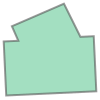

In [32]:
poly

In [33]:
polygons = polygons[0]

In [34]:
polygons = polygons['polygon']

TypeError: list indices must be integers or slices, not str

In [35]:
polygons

[[[213441.57336710393, 191844.68320721015],
  [213457.30763911456, 191845.41523921117],
  [213456.86027911305, 191855.03213521838],
  [213454.53541511297, 191854.9239752181],
  [213451.65426310897, 191860.71469521895],
  [213442.56728710234, 191856.7793352194],
  [213443.68741510808, 191854.23725521564],
  [213441.13432710618, 191854.1184712164],
  [213441.57336710393, 191844.68320721015]]]

In [58]:
with rasterio.open(k_DSM_tif_loc) as src:
    out_image_dsm, out_transform = rasterio.mask.mask(src, [poly], crop=True, filled = True, pad = True)
    out_meta = src.meta

In [59]:
with rasterio.open(k_DTM_tif_loc) as src:
    out_image_dtm, out_transform = rasterio.mask.mask(src, [poly], crop=True, filled = True, pad = True)
    out_meta = src.meta

In [60]:
image_chm = out_image_dtm - out_image_dsm

In [61]:
import matplotlib.pyplot as plt
from rasterio.plot import show
import plotly

<IPython.core.display.Javascript object>


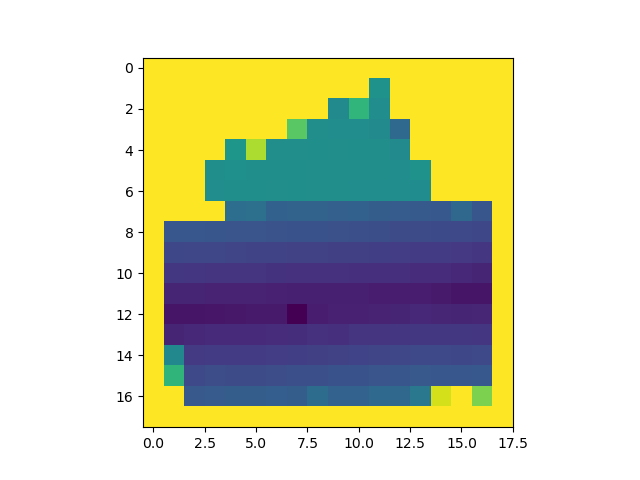

In [62]:
show(image_chm)
plt.show()

# plotly

In [39]:
import plotly.graph_objects as go

In [40]:
%matplotlib notebook

In [41]:
plotly.offline.init_notebook_mode (connected = True)

In [63]:
fig = go.Figure(data = [go.Surface(z=image_chm)])
fig.update_layout(title='Mt Bruno Elevation', autosize=True)
fig.show()

# 3d mesh

In [66]:
import numpy as np

In [71]:
image_chm.shape

(1, 18, 18)

In [75]:
x = np.arange(0, image_chm.shape[1])
y = np.arange(0, image_chm.shape[2])

In [76]:
xx, yy = np.meshgrid(x, y)

In [78]:
fig = go.Figure(data=[go.Mesh3d(x=xx, y=yy, z=image_chm, color='lightpink', opacity=0.50)])
fig.show()

In [10]:
go

NameError: name 'go' is not defined

In [ ]:
DSM_tif.read()

In [ ]:
show(DSM_tif)

#### Dowload link example

In [ ]:
https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/DHMVIIDSMRAS1m_k25.zip

In [ ]:
k_folder

In [ ]:
os.path.exists(k_folder)